## Install Neccessary Packages

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

/Users/hq/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Read In Files

In [3]:
oil=pd.read_csv('./data/oil_dfinal.csv')
tech=pd.read_csv('./data/tech_dfinal.csv')
events=pd.read_csv('./data/final_events.csv')

## Oil Data Cleaning

In [4]:
oil['Date']=oil.Date.str[:10]

In [5]:
oil['Date']=pd.to_datetime(oil['Date'])

In [6]:
oil.dtypes

Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
Dividends              float64
Stock Splits           float64
Ticker                  object
dtype: object

In [7]:
to_drop=['Volume','Dividends','Stock Splits']
oil=oil.drop(columns=to_drop)

## Events Cleaning

In [8]:
events=events.loc[(events['Year']>2000) & (events["Year"]<=2020)]

In [9]:
events['Date']=pd.to_datetime(events['Date'])

In [10]:
events=events[events['Date'].notnull()]

In [11]:
events['Type']=events['Type'].str.replace('Domestic  Terrorism','Domestic Terrorism')


In [12]:
events['Type']=events['Type'].str.replace('Domestic Terrorism ','Domestic Terrorism')

In [13]:
index_to_drop=657

In [14]:
events=events.drop(index=index_to_drop)

In [15]:
events.Type=events['Type'].str.replace('Accident ','Accident')

In [16]:
events=events.rename(columns={'Date':'Event_date'})


In [17]:
events=events.loc[:,['Fatalities','Year','Article','Type','Location','Event_date']]

In [18]:
events.Fatalities=events.Fatalities.str.replace('2,996','2996')

In [19]:
events.Fatalities=events.Fatalities.astype(int)

In [20]:
events.Type.loc[events['Type']=='Terrorism']='Int Terrorism'

<ipython-input-20-b687e3708444>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events.Type.loc[events['Type']=='Terrorism']='Int Terrorism'


In [21]:
events['Location']=events['Location'].str.replace('Sutherland Springs, Texas','Domestic')

## Oil Before an event

In [22]:
#Before event
rolling_window_size = '7D'

oilb = pd.DataFrame()


for index, event_row in events.iterrows():
    event_date = event_row['Event_date']
    
   
    date_range_start = event_date - pd.Timedelta(days=14)
    date_range_end = event_date - pd.Timedelta(days=7)
    
    
    filtered_data = oil[(oil['Date'] >= date_range_start) & (oil['Date'] <= date_range_end)]
    
    filtered_data['Event_date'] = event_date
    filtered_data['Type'] = event_row['Type']
    
    oilb = pd.concat([oilb, filtered_data])
    oilb.reset_index()


<ipython-input-22-5f22f2f0d390>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Event_date'] = event_date
<ipython-input-22-5f22f2f0d390>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Type'] = event_row['Type']
<ipython-input-22-5f22f2f0d390>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

## Oil After event

In [23]:
#After event
rolling_window_size = '7D'

oila = pd.DataFrame()

for index, event_row in events.iterrows():
    event_date = event_row['Event_date']
    
    date_range_end = event_date + pd.Timedelta(days=7)
    
    filtered_data = oil[(oil['Date'] > event_date) & (oil['Date'] <= date_range_end)]
    
    
    filtered_data['Event_date'] = event_date
    filtered_data['Type'] = event_row['Type']
    
    
    oila = pd.concat([oila, filtered_data])

oila = oila.reset_index(drop=True)


<ipython-input-23-097264467110>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Event_date'] = event_date
<ipython-input-23-097264467110>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Type'] = event_row['Type']
<ipython-input-23-097264467110>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [24]:
oilb['Price Change'] = oilb['Close'] - oilb['Open']
oila['Price Change']=oila['Close']-oila['Open']
oilb['Percent Change'] = ((oilb['Close'] - oilb['Open']) / oilb['Open']) * 100
oila['Percent Change'] = ((oila['Close'] - oila['Open']) / oila['Open']) * 100


## Tech Data Clean

In [25]:
tech['Date']=tech.Date.str[:10]

In [26]:
tech['Date']=pd.to_datetime(tech['Date'])

In [27]:
to_drop=['Volume','Dividends','Stock Splits']
tech=tech.drop(columns=to_drop)

## Tech Before Event

In [28]:
rolling_window_size = '7D'

techb = pd.DataFrame()

# Iterate through each historical event
for index, event_row in events.iterrows():
    event_date = event_row['Event_date']
    
    # Calculate the date range for 7 days before the event
    date_range_start = event_date - pd.Timedelta(days=14)
    date_range_end = event_date - pd.Timedelta(days=7)
    
    # Filter oil DataFrame for the specified date range
    filtered_data = tech[(tech['Date'] >= date_range_start) & (tech['Date'] <= date_range_end)]
    
    # Add the 'Event_date' and 'Type' columns from events DataFrame to each row
    filtered_data['Event_date'] = event_date
    filtered_data['Type'] = event_row['Type']
    
    # Append the filtered data to the oilb DataFrame
    techb = pd.concat([techb, filtered_data])
    techb= techb.reset_index(drop=True)

<ipython-input-28-5b2f599a96fb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Event_date'] = event_date
<ipython-input-28-5b2f599a96fb>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Type'] = event_row['Type']
<ipython-input-28-5b2f599a96fb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

## Tech After Event

In [29]:
rolling_window_size = '7D'

techa = pd.DataFrame()

# Iterate through each historical event
for index, event_row in events.iterrows():
    event_date = event_row['Event_date']
    
    # Calculate the date range for 7 days after the event
    date_range_end = event_date + pd.Timedelta(days=7)
    
    # Filter oil DataFrame for the specified date range
    filtered_data = tech[(tech['Date'] > event_date) & (tech['Date'] <= date_range_end)]
    
    # Add the 'Event_date' and 'Type' columns from events DataFrame to each row
    filtered_data['Event_date'] = event_date
    filtered_data['Type'] = event_row['Type']
    
    # Append the filtered data to the oilb DataFrame
    techa = pd.concat([techa, filtered_data])

# Reset index of the resulting DataFrame
techa = techa.reset_index(drop=True)



<ipython-input-29-769565b03052>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Event_date'] = event_date
<ipython-input-29-769565b03052>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Type'] = event_row['Type']
<ipython-input-29-769565b03052>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [30]:
techb['Price Change'] = techb['Close'] - techb['Open']
techb['Percent Change'] = ((techb['Close'] - techb['Open']) / techb['Open']) * 100
techa['Price Change'] = techa['Close'] - techa['Open']
techa['Percent Change'] = ((techa['Open'] - techa['Close']) / techa['Open']) * 100


# EDA

## Average Open and Close Price Tech and Oil

In [31]:
oilb_oav=oilb.groupby('Type')['Open'].mean().to_frame().reset_index()
oila_oav=oila.groupby('Type')['Open'].mean().to_frame().reset_index()


### Open and close visualization oil

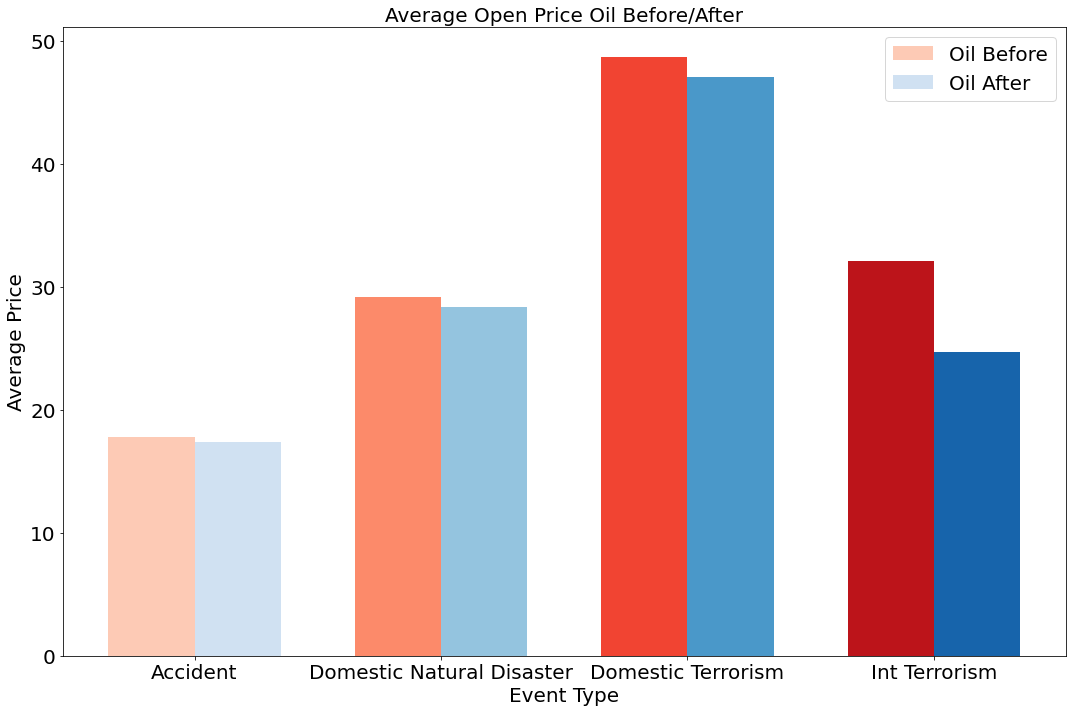

In [32]:

# Define custom color palettes for oilb (Reds) and oila (Blues)
oilb_palette = sns.color_palette("Reds", n_colors=len(oilb['Type'].unique()))
oila_palette = sns.color_palette("Blues", n_colors=len(oila['Type'].unique()))

# Calculate average open prices for both dataframes
avb_open = oilb.groupby('Type')['Open'].mean()
ava_open = oila.groupby('Type')['Open'].mean()

# Create a figure and axes
plt.figure(figsize=(15, 10))
ax = plt.gca()

# Set the width of the bars
bar_width = 0.35

# Create an array of x values for the bars
x = range(len(avb_open))

# Plot the 'oilb' bars with the Reds palette
bar1 = ax.bar(x, avb_open, bar_width, color=oilb_palette, label='Oil Before')

# Plot the 'oila' bars with the Blues palette
bar2 = ax.bar([i + bar_width for i in x], ava_open, bar_width, color=oila_palette, label='Oil After')
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x',labelsize=20)
plt.ylabel('Average Price',fontsize=20)
plt.xlabel('Event Type',fontsize=20)
plt.title('Average Open Price Oil Before/After',fontsize=20)

# Set the x-axis ticks and labels
ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(avb_open.index)

# Combine the legends for both sets of bars
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='best',fontsize=20)

plt.tight_layout()
plt.show()


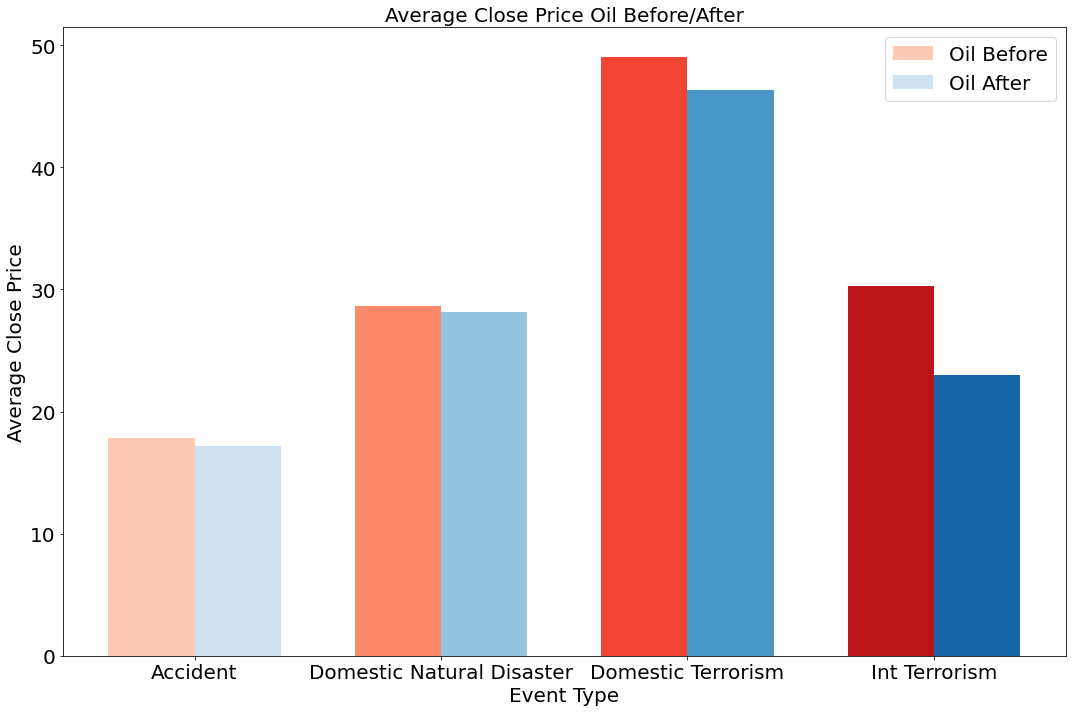

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom color palettes for oilb (Reds) and oila (Blues)
oilb_palette = sns.color_palette("Reds", n_colors=len(oilb['Type'].unique()))
oila_palette = sns.color_palette("Blues", n_colors=len(oila['Type'].unique()))

# Calculate average close prices for both dataframes
avb_close = oilb.groupby('Type')['Close'].mean()
ava_close = oila.groupby('Type')['Close'].mean()

# Create a figure and axes
plt.figure(figsize=(15, 10))
ax = plt.gca()

# Set the width of the bars
bar_width = 0.35

# Create an array of x values for the bars
x = range(len(avb_close))

# Plot the 'oilb' bars with the Reds palette
bar1 = ax.bar(x, avb_close, bar_width, color=oilb_palette, label='Oil Before')

# Plot the 'oila' bars with the Blues palette
bar2 = ax.bar([i + bar_width for i in x], ava_close, bar_width, color=oila_palette, label='Oil After')
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x',labelsize=20)
plt.ylabel('Average Close Price',fontsize=20)
plt.xlabel('Event Type',fontsize=20)
plt.title('Average Close Price Oil Before/After',fontsize=20)

# Set the x-axis ticks and labels
ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(avb_close.index)

# Combine the legends for both sets of bars
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='best',fontsize=20)

plt.tight_layout()
plt.show()


### Open and Close Tech Visualization

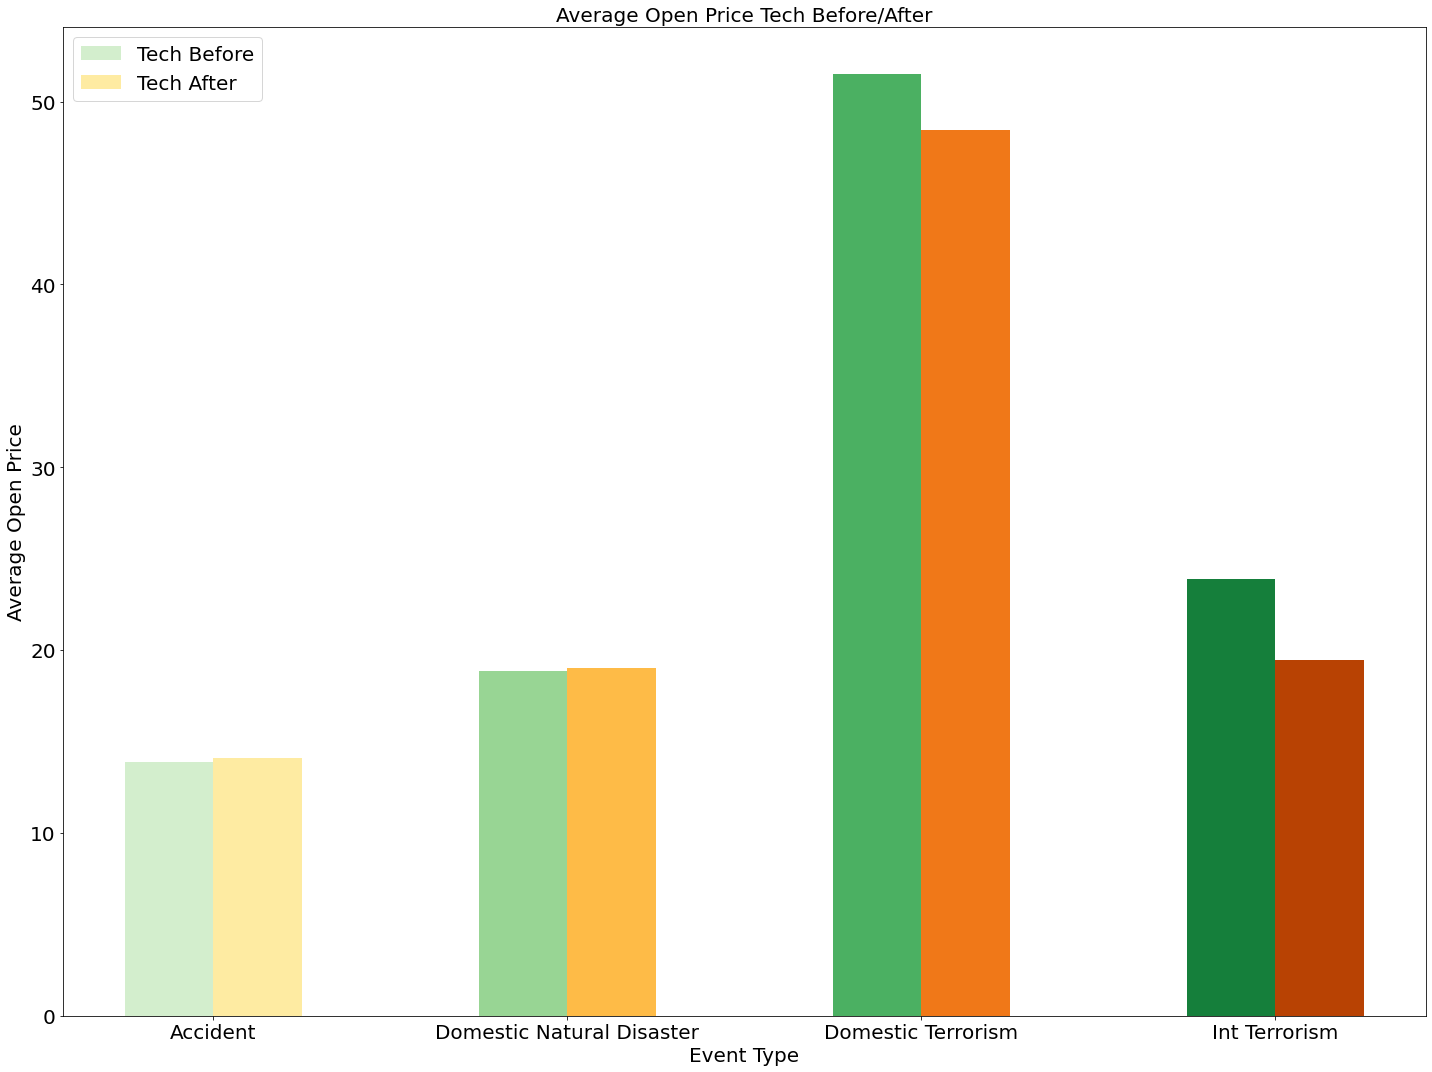

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom color palettes for techb (Greens) and techa (YlOrBr)
techb_palette = sns.color_palette("Greens", n_colors=len(techb['Type'].unique()))
techa_palette = sns.color_palette("YlOrBr", n_colors=len(techa['Type'].unique()))

# Calculate average open prices for both dataframes
avb_open = techb.groupby('Type')['Open'].mean()
ava_open = techa.groupby('Type')['Open'].mean()

# Create a figure and axes
plt.figure(figsize=(20, 15))
ax = plt.gca()

# Set the width of the bars
bar_width = 0.25

# Create an array of x values for the bars
x = range(len(avb_open))

# Plot the 'techb' bars with the Greens palette
bar1 = ax.bar(x, avb_open, bar_width, color=techb_palette, label='Tech Before')

# Plot the 'techa' bars with the YlOrBr palette
bar2 = ax.bar([i + bar_width for i in x], ava_open, bar_width, color=techa_palette, label='Tech After')

plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x',labelsize=20)
plt.ylabel('Average Open Price',fontsize=20)
plt.xlabel('Event Type',fontsize=20)
plt.title('Average Open Price Tech Before/After',fontsize=20)

# Set the x-axis ticks and labels
ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(avb_open.index)

# Combine the legends for both sets of bars
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='upper left',fontsize=20)

plt.tight_layout()
plt.show()


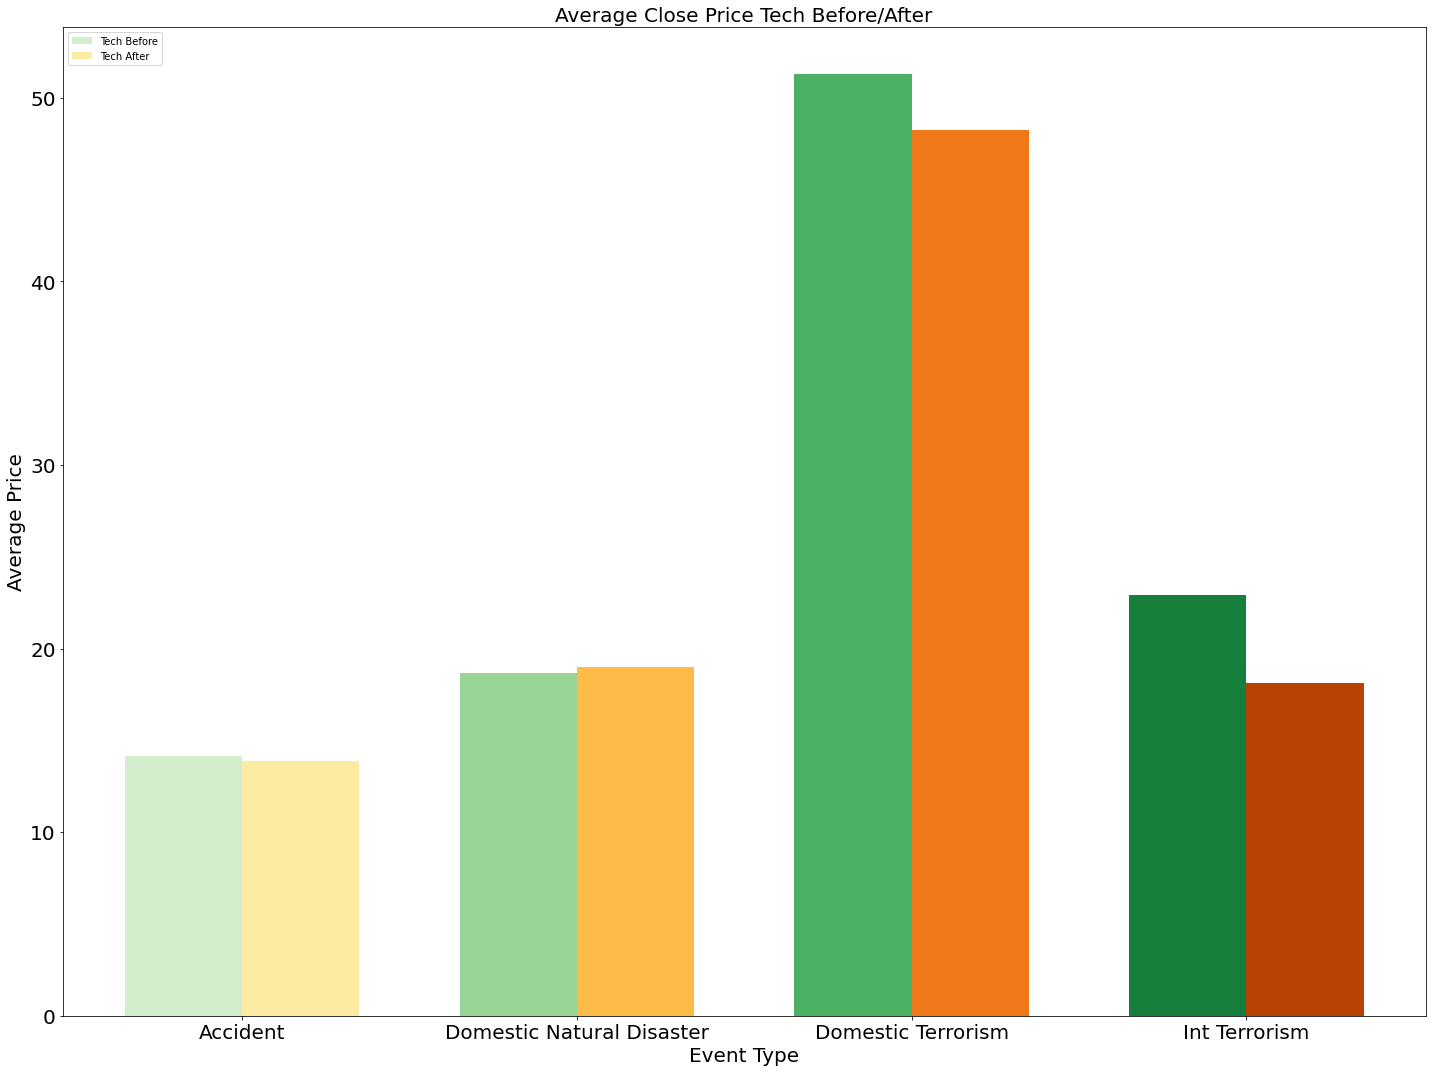

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom color palettes for techb (Greens) and techa (YlOrBr)
techb_palette = sns.color_palette("Greens", n_colors=len(techb['Type'].unique()))
techa_palette = sns.color_palette("YlOrBr", n_colors=len(techa['Type'].unique()))

# Calculate average close prices for both dataframes
avb_close = techb.groupby('Type')['Close'].mean()
ava_close = techa.groupby('Type')['Close'].mean()

# Create a figure and axes
plt.figure(figsize=(20, 15))
ax = plt.gca()

# Set the width of the bars
bar_width = 0.35

# Create an array of x values for the bars
x = range(len(avb_close))

# Plot the 'techb' bars with the Greens palette
bar1 = ax.bar(x, avb_close, bar_width, color=techb_palette, label='Tech Before')

# Plot the 'techa' bars with the YlOrBr palette
bar2 = ax.bar([i + bar_width for i in x], ava_close, bar_width, color=techa_palette, label='Tech After')

# Set the x-axis ticks and labels
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(avb_close.index)  # Use the 'Type' values as labels

plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.ylabel('Average Price',fontsize=20)
plt.xlabel('Event Type',fontsize=20)
plt.title('Average Close Price Tech Before/After',fontsize=20)

ax.legend(loc='upper left')

plt.tight_layout()
plt.show()


### Average Price Change Oil and Tech Visualization

#### Oil

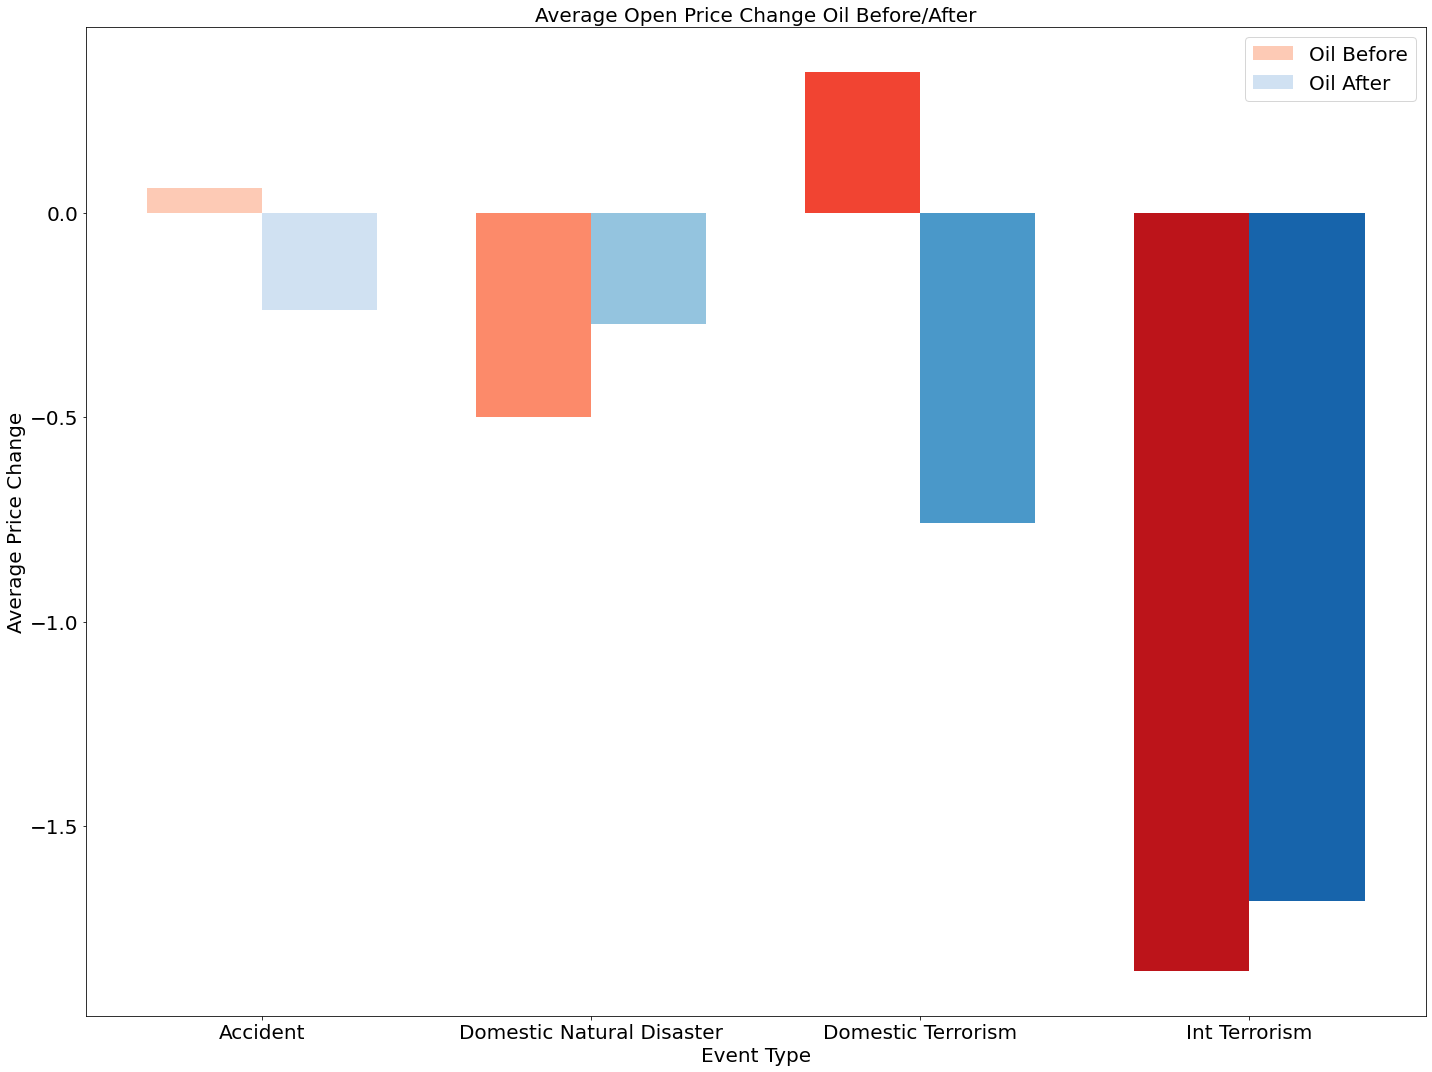

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom color palettes for oilb (Reds) and oila (Blues)
oilb_palette = sns.color_palette("Reds", n_colors=len(oilb['Type'].unique()))
oila_palette = sns.color_palette("Blues", n_colors=len(oila['Type'].unique()))

# Calculate average price changes for both dataframes
avb_pchange = oilb.groupby('Type')['Price Change'].mean()
ava_pchange = oila.groupby('Type')['Price Change'].mean()

# Create a figure and axes
plt.figure(figsize=(20, 15))
ax = plt.gca()

# Set the width of the bars
bar_width = 0.35

# Create an array of x values for the bars
x = range(len(avb_pchange))

# Plot the 'oilb' bars with the Reds palette
bar1 = ax.bar(x, avb_pchange, bar_width, color=oilb_palette, label='Oil Before')

# Plot the 'oila' bars with the Blues palette
bar2 = ax.bar([i + bar_width for i in x], ava_pchange, bar_width, color=oila_palette, label='Oil After')

plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.ylabel('Average Price Change',fontsize=20)
plt.xlabel('Event Type',fontsize=20)
plt.title('Average Open Price Change Oil Before/After',fontsize=20)

# Set the x-axis ticks and labels
ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(avb_pchange.index)

# Combine the legends for both sets of bars
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='best',fontsize=20)

plt.tight_layout()
plt.show()


#### Tech

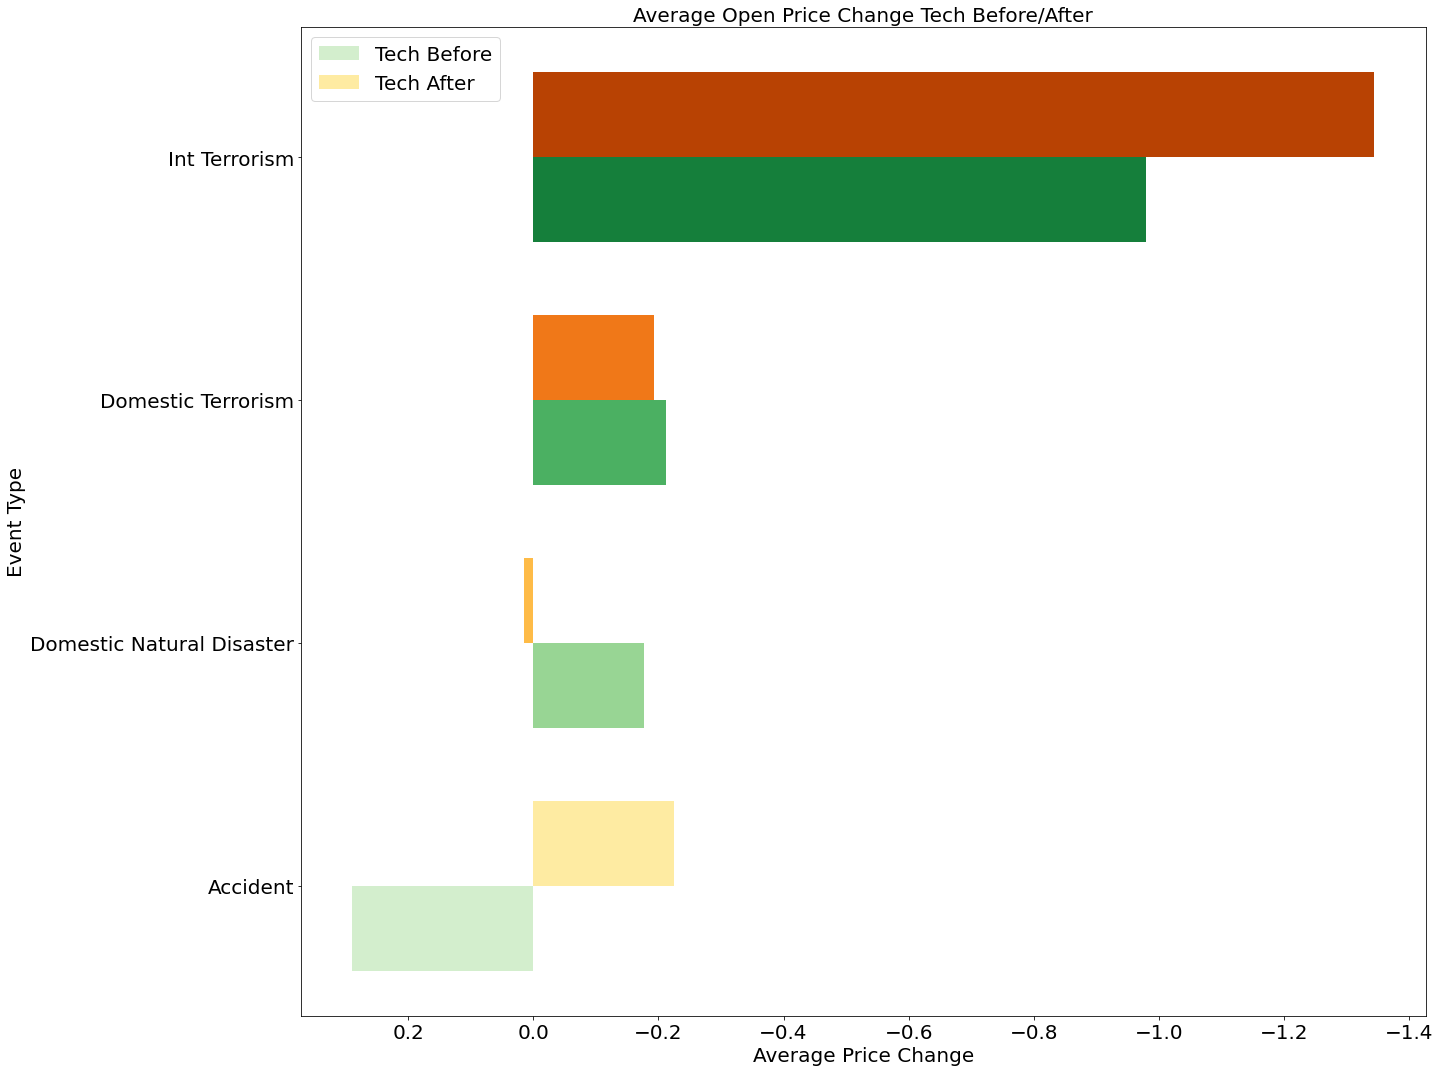

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom color palettes for techb (Greens) and techa (YlOrBr)
techb_palette = sns.color_palette("Greens", n_colors=len(techb['Type'].unique()))
techa_palette = sns.color_palette("YlOrBr", n_colors=len(techa['Type'].unique()))

# Calculate average price changes for both dataframes
avb_pchange = techb.groupby('Type')['Price Change'].mean()
ava_pchange = techa.groupby('Type')['Price Change'].mean()

# Create a figure and axes
plt.figure(figsize=(20, 15))
ax = plt.gca()

# Set the height of the bars
bar_height = 0.35

# Create an array of y values for the bars
y = range(len(avb_pchange))

# Plot the 'techb' bars with the Greens palette
bar1 = ax.barh(y, avb_pchange, bar_height, color=techb_palette, label='Tech Before')

# Plot the 'techa' bars with the YlOrBr palette
bar2 = ax.barh([i + bar_height for i in y], ava_pchange, bar_height, color=techa_palette, label='Tech After')

plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.xlabel('Average Price Change',fontsize=20)
plt.ylabel('Event Type',fontsize=20)
plt.title('Average Open Price Change Tech Before/After',fontsize=20)

# Set the y-axis ticks and labels
ax.set_yticks([i + bar_height/2 for i in y])
ax.set_yticklabels(avb_pchange.index)

# Combine the legends for both sets of bars
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='best',fontsize=20)

plt.tight_layout()
plt.gca().invert_xaxis()
plt.show()


## Oil vs Tech Average Open and Close 

### Open Oil vs Tech Before

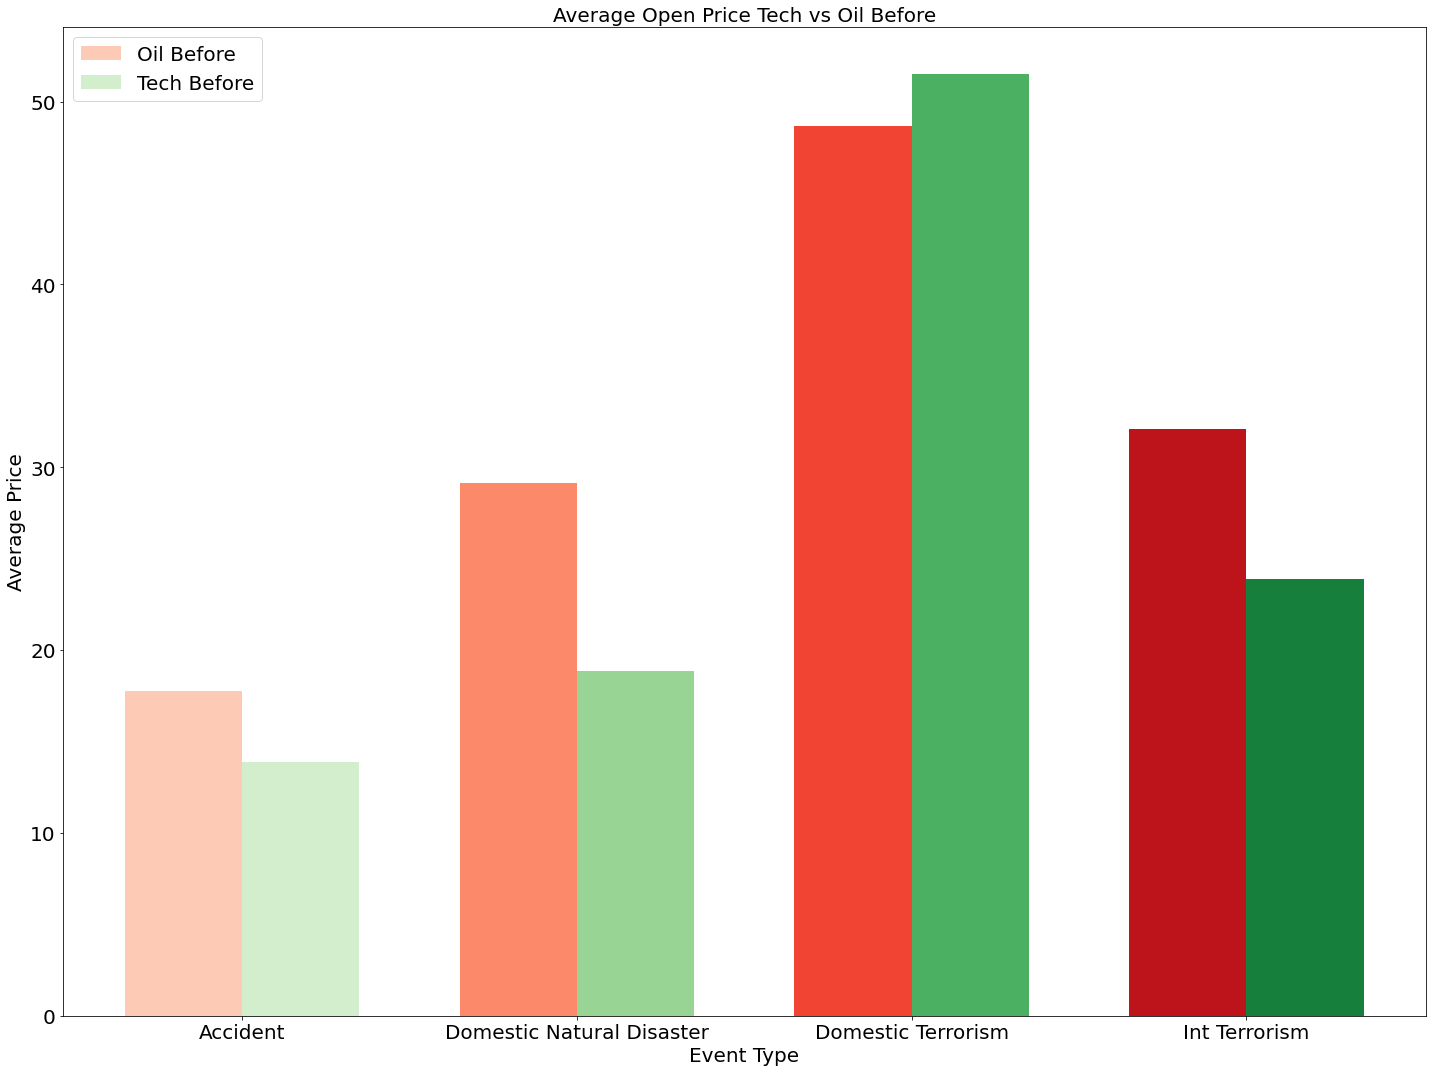

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom color palettes for oilb (Reds) and techb (Greens)
oilb_palette = sns.color_palette("Reds", n_colors=len(oilb['Type'].unique()))
techb_palette = sns.color_palette("Greens", n_colors=len(techb['Type'].unique()))

# Calculate average open prices for both dataframes
avb_open = oilb.groupby('Type')['Open'].mean()
ava_open = techb.groupby('Type')['Open'].mean()

# Create a figure and axes
plt.figure(figsize=(20, 15))
ax = plt.gca()

# Set the width of the bars
bar_width = 0.35

# Create an array of x values for the bars
x = range(len(avb_open))

# Plot the 'oilb' bars with the Reds palette
bar1 = ax.bar(x, avb_open, bar_width, color=oilb_palette, label='Oil Before')

# Plot the 'techb' bars with the Greens palette
bar2 = ax.bar([i + bar_width for i in x], ava_open, bar_width, color=techb_palette, label='Tech Before')

plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.ylabel('Average Price',fontsize=20)
plt.xlabel('Event Type',fontsize=20)
plt.title('Average Open Price Tech vs Oil Before',fontsize=20)

# Set the x-axis ticks and labels
ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(avb_open.index)

# Combine the legends for both sets of bars
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='upper left',fontsize=20)

plt.tight_layout()
plt.show()


### Open Oil vs Tech After

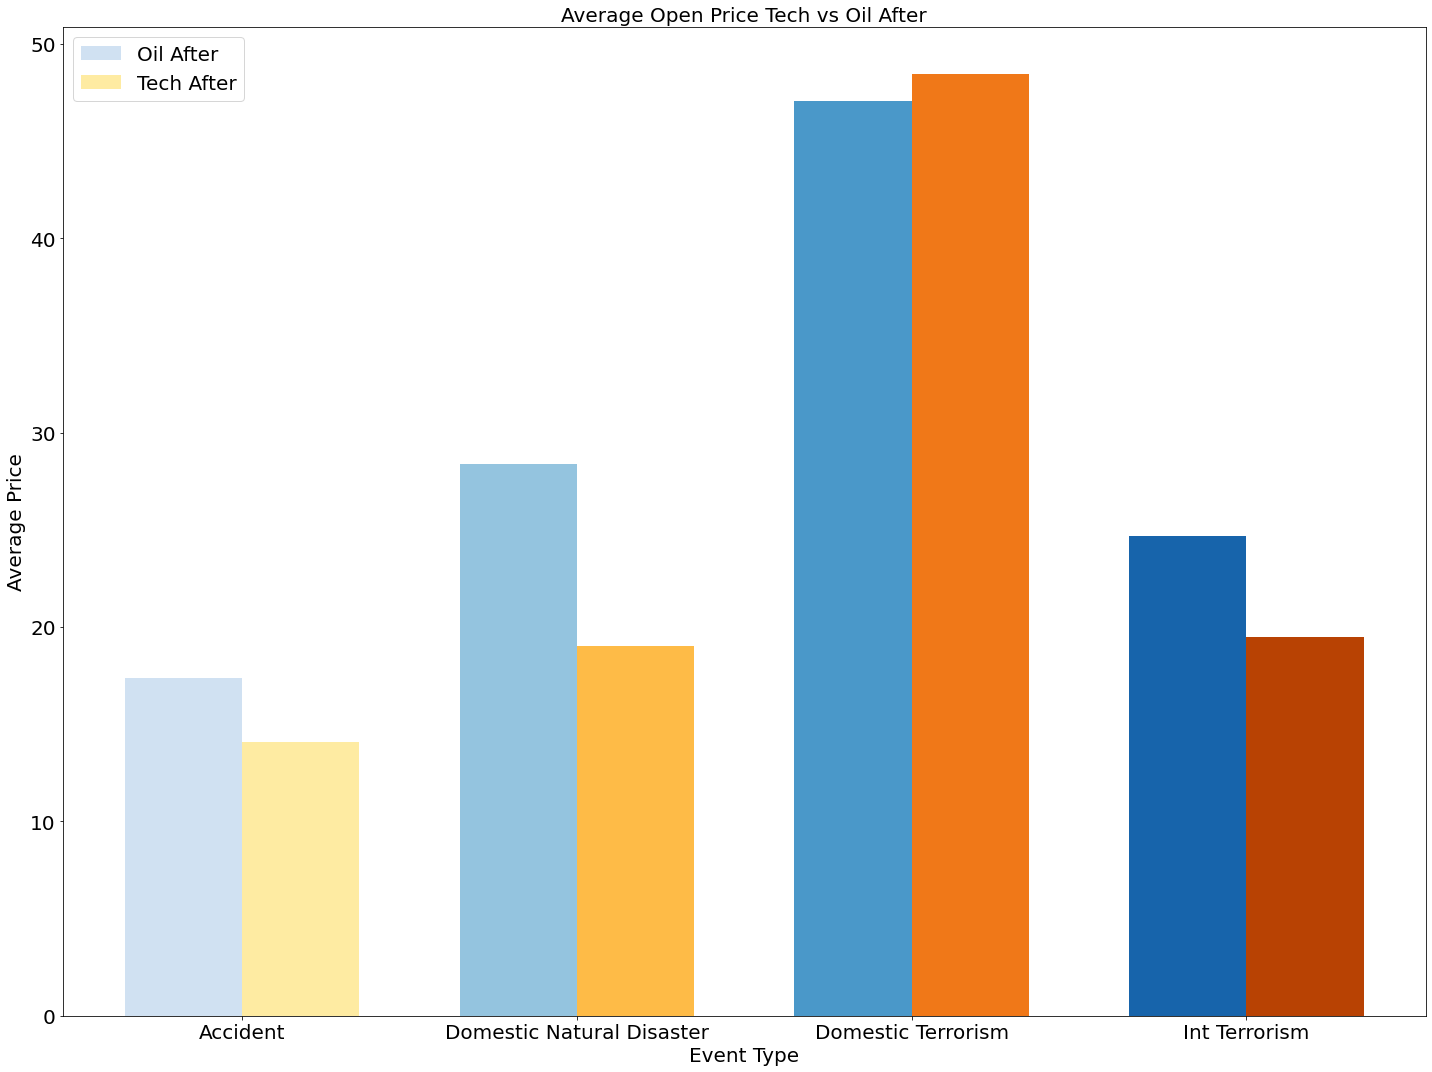

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom color palettes for oila (Blues) and techa (YlOrBr)
oila_palette = sns.color_palette("Blues", n_colors=len(oila['Type'].unique()))
techa_palette = sns.color_palette("YlOrBr", n_colors=len(techa['Type'].unique()))

# Calculate average open prices for both dataframes
avb_open = oila.groupby('Type')['Open'].mean()
ava_open = techa.groupby('Type')['Open'].mean()

# Create a figure and axes
plt.figure(figsize=(20, 15))
ax = plt.gca()

# Set the width of the bars
bar_width = 0.35

# Create an array of x values for the bars
x = range(len(avb_open))

# Plot the 'oila' bars with the Blues palette
bar1 = ax.bar(x, avb_open, bar_width, color=oila_palette, label='Oil After')

# Plot the 'techa' bars with the YlOrBr palette
bar2 = ax.bar([i + bar_width for i in x], ava_open, bar_width, color=techa_palette, label='Tech After')

plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.ylabel('Average Price',fontsize=20)
plt.xlabel('Event Type',fontsize=20)
plt.title('Average Open Price Tech vs Oil After',fontsize=20)

# Set the x-axis ticks and labels
ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(avb_open.index)

# Combine the legends for both sets of bars
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='upper left',fontsize=20)

plt.tight_layout()
plt.show()


### Close oil vs Tech After

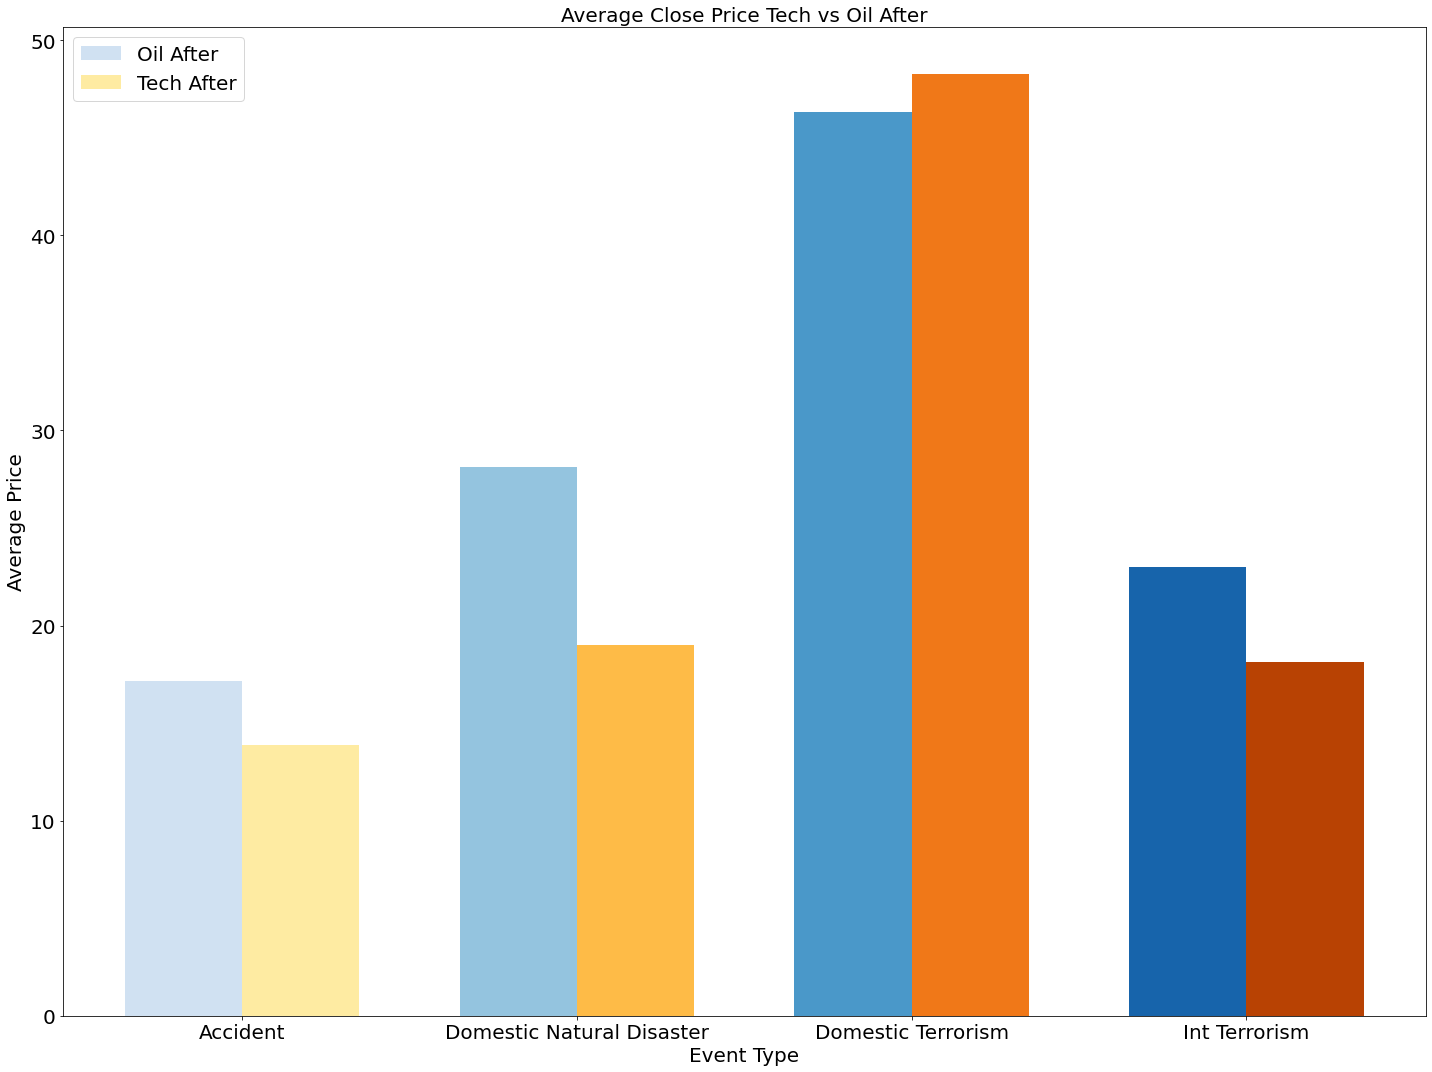

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom color palettes for oila (Blues) and techa (YlOrBr)
oila_palette = sns.color_palette("Blues", n_colors=len(oila['Type'].unique()))
techa_palette = sns.color_palette("YlOrBr", n_colors=len(techa['Type'].unique()))

# Calculate average close prices for both dataframes
avb_open = oila.groupby('Type')['Close'].mean()
ava_open = techa.groupby('Type')['Close'].mean()

# Create a figure and axes
plt.figure(figsize=(20, 15))
ax = plt.gca()

# Set the width of the bars
bar_width = 0.35

# Create an array of x values for the bars
x = range(len(avb_open))

# Plot the 'oila' bars with the Blues palette
bar1 = ax.bar(x, avb_open, bar_width, color=oila_palette, label='Oil After')

# Plot the 'techa' bars with the YlOrBr palette
bar2 = ax.bar([i + bar_width for i in x], ava_open, bar_width, color=techa_palette, label='Tech After')

plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.ylabel('Average Price',fontsize=20)
plt.xlabel('Event Type',fontsize=20)
plt.title('Average Close Price Tech vs Oil After',fontsize=20)

# Set the x-axis ticks and labels
ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(avb_open.index)

# Combine the legends for both sets of bars
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='upper left',fontsize=20)

plt.tight_layout()
plt.show()


### Close Oil vs Tech Before

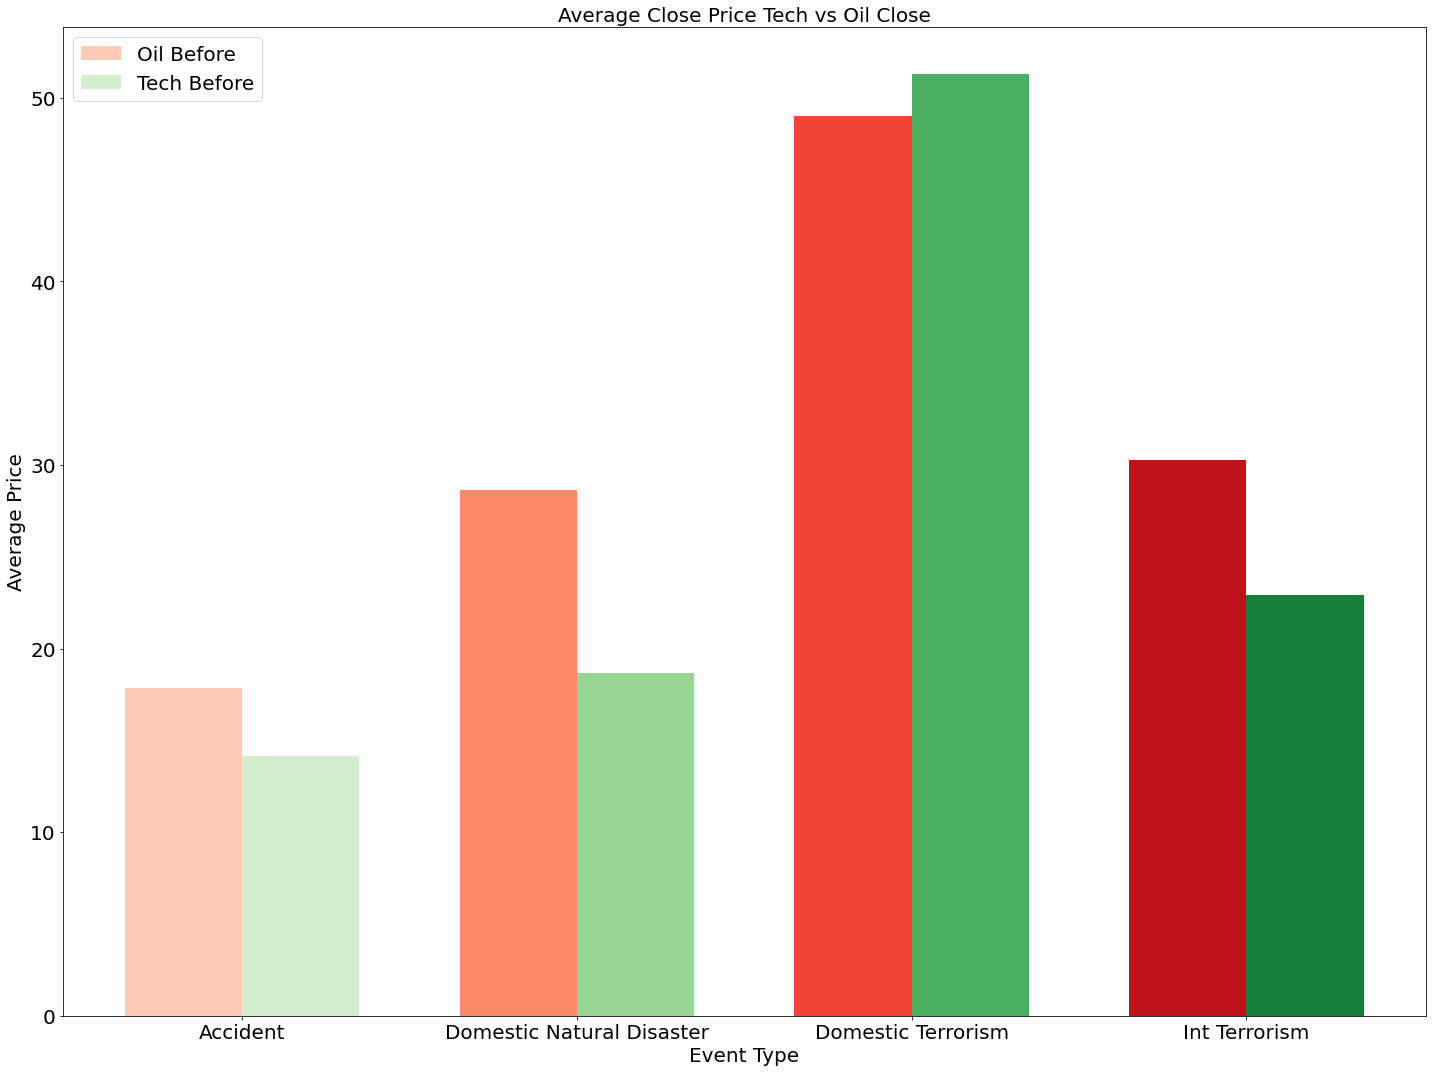

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define custom color palettes for oilb (shades of red) and techb (shades of green)
oilb_palette = sns.color_palette("Reds", n_colors=len(oilb['Type'].unique()))
techb_palette = sns.color_palette("Greens", n_colors=len(techb['Type'].unique()))

# Calculate average open prices for both dataframes
avb_open = oilb.groupby('Type')['Close'].mean()
ava_open = techb.groupby('Type')['Close'].mean()

# Create a figure and axes
plt.figure(figsize=(20, 15))
ax = plt.gca()

# Set the width of the bars
bar_width = 0.35

# Create an array of x values for the bars
x = np.arange(len(avb_open))

# Plot the 'oilb' bars
bar1 = ax.bar(x - bar_width/2, avb_open, bar_width, color=oilb_palette, label='Oil Before')

# Plot the 'techb' bars
bar2 = ax.bar(x + bar_width/2, ava_open, bar_width, color=techb_palette, label='Tech Before')

plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.ylabel('Average Price',fontsize=20)
plt.xlabel('Event Type',fontsize=20)
plt.title('Average Close Price Tech vs Oil Close',fontsize=20)

# Set the x-axis ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(avb_open.index)

# Combine the legends for both sets of bars
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='upper left',fontsize=20)
plt.tight_layout()
plt.show()


### Price Change Oil vs Tech Before 

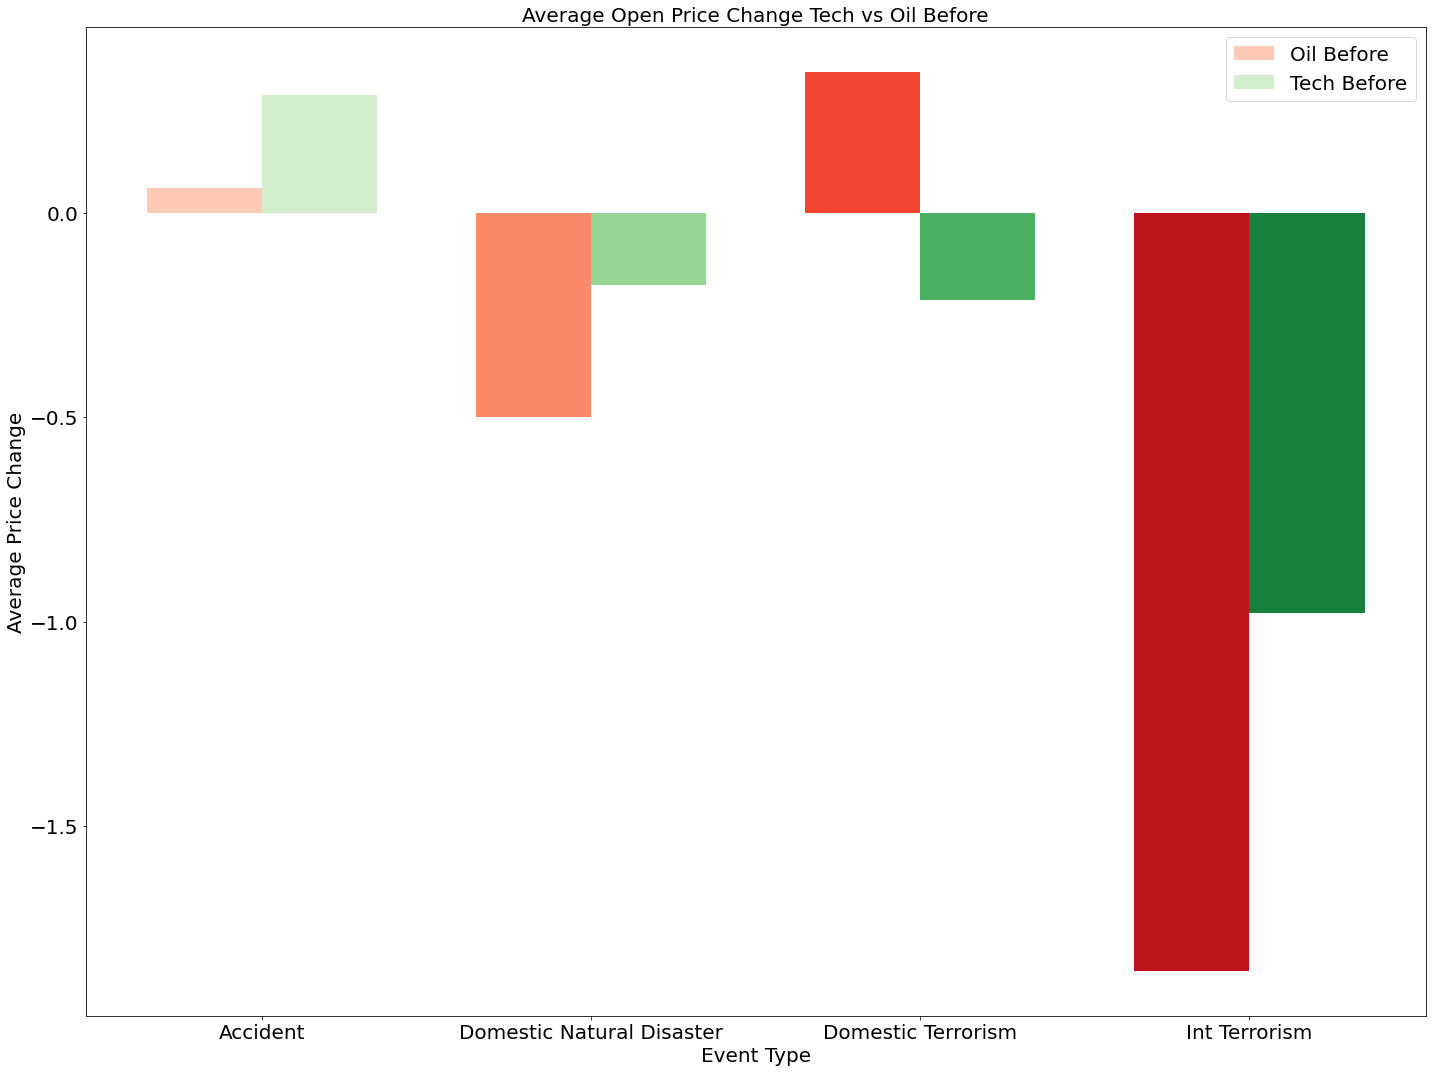

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom color palettes for oilb (Reds) and techb (Greens)
oilb_palette = sns.color_palette("Reds", n_colors=len(oilb['Type'].unique()))
techb_palette = sns.color_palette("Greens", n_colors=len(techb['Type'].unique()))

# Calculate average price changes for both dataframes
avb_open = oilb.groupby('Type')['Price Change'].mean()
ava_open = techb.groupby('Type')['Price Change'].mean()

# Create a figure and axes
plt.figure(figsize=(20, 15))
ax = plt.gca()

# Set the width of the bars
bar_width = 0.35

# Create an array of x values for the bars
x = range(len(avb_open))

# Plot the 'oilb' bars with the Reds palette
bar1 = ax.bar(x, avb_open, bar_width, color=oilb_palette, label='Oil Before')

# Plot the 'techb' bars with the Greens palette
bar2 = ax.bar([i + bar_width for i in x], ava_open, bar_width, color=techb_palette, label='Tech Before')

plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.ylabel('Average Price Change',fontsize=20)
plt.xlabel('Event Type',fontsize=20)
plt.title('Average Open Price Change Tech vs Oil Before',fontsize=20)

# Set the x-axis ticks and labels
ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(avb_open.index)

# Combine the legends for both sets of bars
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='best',fontsize=20)

plt.tight_layout()
plt.show()


### PriceChange Oil vs Tech After

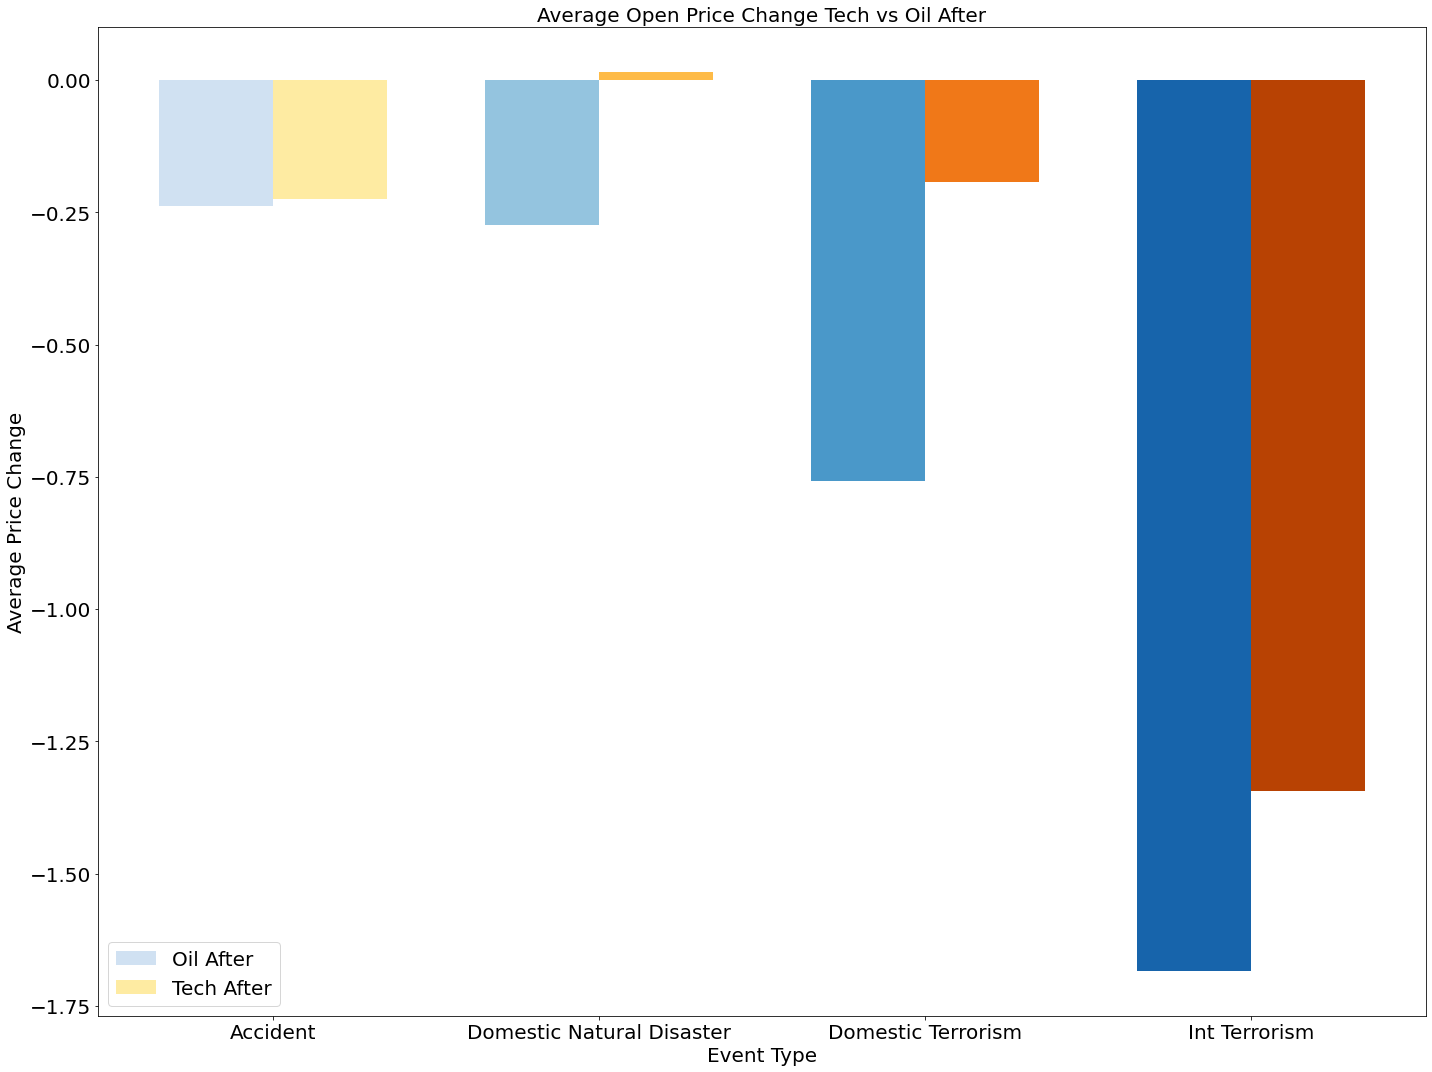

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom color palettes for oila (Blues) and techa (YlOrBr)
oila_palette = sns.color_palette("Blues", n_colors=len(oila['Type'].unique()))
techa_palette = sns.color_palette("YlOrBr", n_colors=len(techa['Type'].unique()))

# Calculate average price changes for both dataframes
avb_open = oila.groupby('Type')['Price Change'].mean()
ava_open = techa.groupby('Type')['Price Change'].mean()

# Create a figure and axes
plt.figure(figsize=(20, 15))
ax = plt.gca()

# Set the width of the bars
bar_width = 0.35

# Create an array of x values for the bars
x = range(len(avb_open))

# Plot the 'oila' bars with the Blues palette
bar1 = ax.bar(x, avb_open, bar_width, color=oila_palette, label='Oil After')

# Plot the 'techa' bars with the YlOrBr palette
bar2 = ax.bar([i + bar_width for i in x], ava_open, bar_width, color=techa_palette, label='Tech After')

plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.ylabel('Average Price Change',fontsize=20)
plt.xlabel('Event Type',fontsize=20)
plt.title('Average Open Price Change Tech vs Oil After',fontsize=20)

# Set the x-axis ticks and labels
ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(avb_open.index)

# Combine the legends for both sets of bars
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='best',fontsize=20)

plt.tight_layout()
plt.show()


### Oil vs Tech Percent Change Before

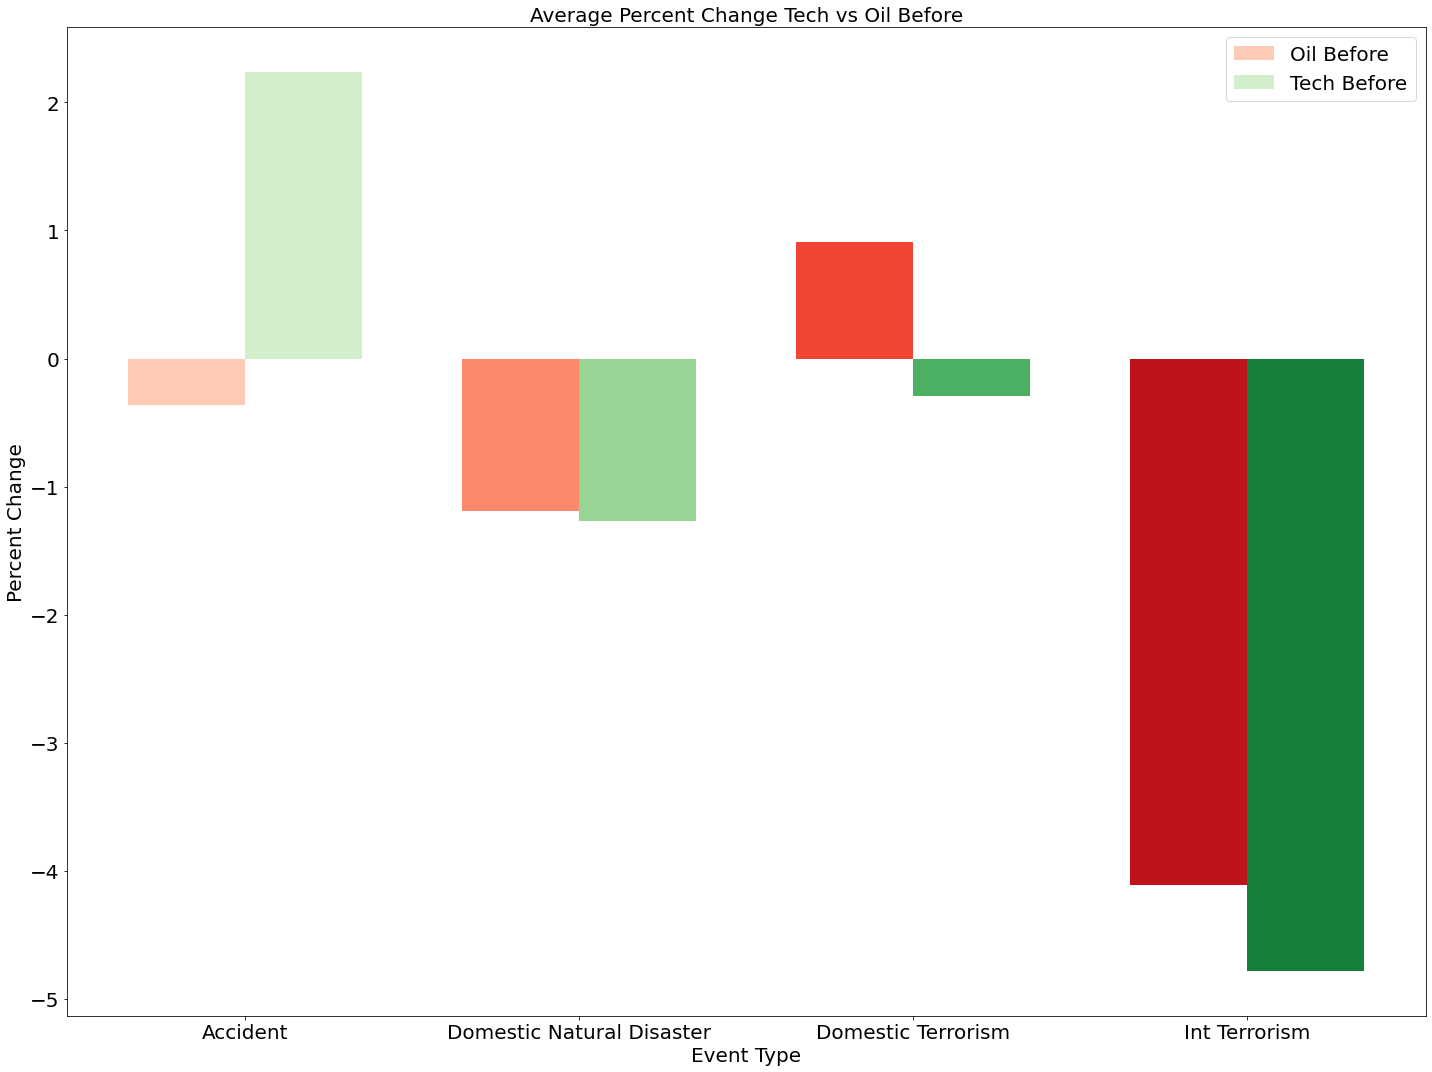

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom color palettes for oilb (Reds) and techb (Greens)
oilb_palette = sns.color_palette("Reds", n_colors=len(oilb['Type'].unique()))
techb_palette = sns.color_palette("Greens", n_colors=len(techb['Type'].unique()))

# Calculate average percent changes for both dataframes
avb_open = oilb.groupby('Type')['Percent Change'].mean()
ava_open = techb.groupby('Type')['Percent Change'].mean()

# Create a figure and axes
plt.figure(figsize=(20, 15))
ax = plt.gca()

# Set the width of the bars
bar_width = 0.35

# Create an array of x values for the bars
x = range(len(avb_open))

# Plot the 'oilb' bars with the Reds palette
bar1 = ax.bar(x, avb_open, bar_width, color=oilb_palette, label='Oil Before')

# Plot the 'techb' bars with the Greens palette
bar2 = ax.bar([i + bar_width for i in x], ava_open, bar_width, color=techb_palette, label='Tech Before')

plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.ylabel('Percent Change',fontsize=20)
plt.xlabel('Event Type',fontsize=20)
plt.title('Average Percent Change Tech vs Oil Before',fontsize=20)

# Set the x-axis ticks and labels
ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(avb_open.index)

# Combine the legends for both sets of bars
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='best',fontsize=20)

plt.tight_layout()
plt.show()


### Oil vs Tech Percent Change After

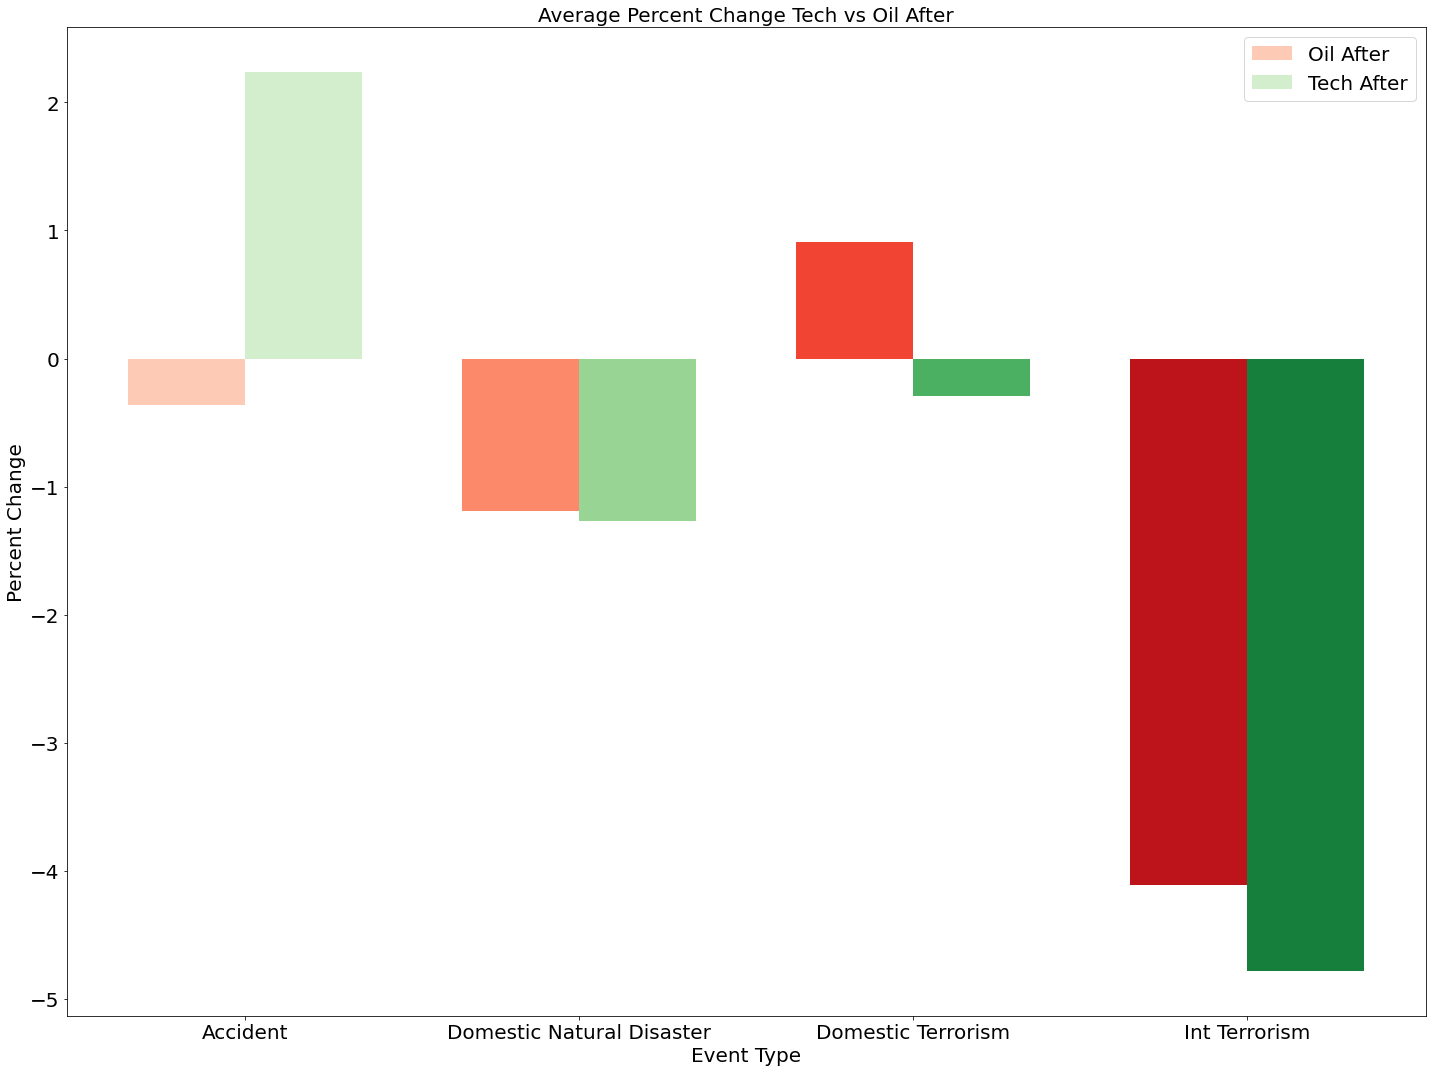

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom color palettes for oilb (Reds) and techb (Greens)
oilb_palette = sns.color_palette("Reds", n_colors=len(oilb['Type'].unique()))
techb_palette = sns.color_palette("Greens", n_colors=len(techb['Type'].unique()))

# Calculate average percent changes for both dataframes
avb_open = oilb.groupby('Type')['Percent Change'].mean()
ava_open = techb.groupby('Type')['Percent Change'].mean()

# Create a figure and axes
plt.figure(figsize=(20, 15))
ax = plt.gca()

# Set the width of the bars
bar_width = 0.35

# Create an array of x values for the bars
x = range(len(avb_open))

# Plot the 'oilb' bars with the Reds palette
bar1 = ax.bar(x, avb_open, bar_width, color=oilb_palette, label='Oil After')

# Plot the 'techb' bars with the Greens palette
bar2 = ax.bar([i + bar_width for i in x], ava_open, bar_width, color=techb_palette, label='Tech After')

plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.ylabel('Percent Change',fontsize=20)
plt.xlabel('Event Type',fontsize=20)
plt.title('Average Percent Change Tech vs Oil After',fontsize=20)

# Set the x-axis ticks and labels
ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(avb_open.index)

# Combine the legends for both sets of bars
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='best',fontsize=20)

plt.tight_layout()
plt.show()


## Effect Size of Oil Industry Close And Open prices

In [46]:
grouped_oilb = oilb.groupby('Type')
grouped_oila = oila.groupby('Type')
measurements = ['Open', 'Close']
effect_sizes_dict = {'Type': []}

for measurement in measurements:
    effect_sizes_dict[measurement] = []


for group, group_data_oilb in grouped_oilb:
    group_data_oila = grouped_oila.get_group(group)
    
    effect_sizes_dict['Type'].append(group)
    
    for measurement in measurements:
        mean_oilb = group_data_oilb[measurement].mean()
        mean_oila = group_data_oila[measurement].mean()
        pooled_std = np.sqrt((group_data_oilb[measurement].std()**2 + group_data_oila[measurement].std()**2) / 2)
        
        effect_size = (mean_oila - mean_oilb) / pooled_std
        effect_sizes_dict[measurement].append(effect_size)
effect_cohen_oil = pd.DataFrame(effect_sizes_dict)
effect_cohen_oil


,Type,Open,Close
0,Accident,-0.040579,-0.073736
1,Domestic Natural Disaster,-0.040841,-0.028357
2,Domestic Terrorism,-0.071214,-0.121475
3,Int Terrorism,-0.395372,-0.413035


<Figure size 1584x3960 with 0 Axes>

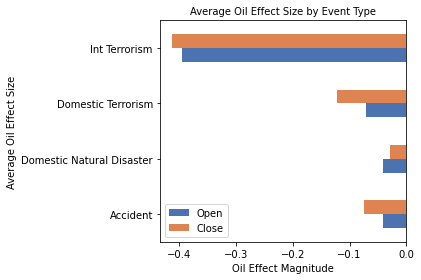

''

In [47]:
sns.set_palette("deep")

# Group the DataFrame by 'Type' and calculate the mean effect size for each measurement
avg_effect_size_by_type = effect_cohen_oil.groupby('Type')[['Open', 'Close']].mean()

# Create a bar plot
plt.figure(figsize=(22, 55))
avg_effect_size_by_type.plot(kind='barh')

# Adding labels and title
plt.xlabel('Oil Effect Magnitude',fontsize=10)
plt.ylabel('Average Oil Effect Size',fontsize=10)
plt.title('Average Oil Effect Size by Event Type',fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()
;

In [48]:
grouped_oilb = oilb.groupby('Type')
grouped_oila = oila.groupby('Type')

measurements = ['Open', 'High', 'Low', 'Close']

effect_sizes_dict = {'Type': []}

for measurement in measurements:
    effect_sizes_dict[measurement] = []

for group, group_data_oilb in grouped_oilb:
    group_data_oila = grouped_oila.get_group(group)
    
    effect_sizes_dict['Type'].append(group)
    
    for measurement in measurements:
        mean_oilb = group_data_oilb[measurement].mean()
        mean_oila = group_data_oila[measurement].mean()
        std_oilb = group_data_oilb[measurement].std()
        std_oila = group_data_oila[measurement].std()
        n_oilb = len(group_data_oilb)
        n_oila = len(group_data_oila)
        
        # Calculate Hedges' g effect size for the current measurement and group
        pooled_std = np.sqrt(((std_oilb ** 2 * (n_oilb - 1)) + (std_oila ** 2 * (n_oila - 1))) / (n_oilb + n_oila - 2))
        hedges_g = (mean_oila - mean_oilb) / pooled_std
        
        # Store the effect size for the current measurement
        effect_sizes_dict[measurement].append(hedges_g)

# Create a DataFrame from the effect_sizes_dict
effect_hedge = pd.DataFrame(effect_sizes_dict)
effect_hedge


,Type,Open,High,Low,Close
0,Accident,-0.040579,-0.077511,-0.097728,-0.073736
1,Domestic Natural Disaster,-0.040841,-0.031177,-0.036524,-0.028357
2,Domestic Terrorism,-0.071193,-0.101530,-0.107756,-0.121402
3,Int Terrorism,-0.388685,-0.372132,-0.403129,-0.408031


### Effect Size Tech Industry Open and Close

In [49]:
grouped_techb = techb.groupby('Type')
grouped_techa = techa.groupby('Type')
measurements = ['Open', 'High', 'Low', 'Close']
effect_sizes_dict = {'Type': []}

for measurement in measurements:
    effect_sizes_dict[measurement] = []


for group, group_data_techb in grouped_techb:
    group_data_techa = grouped_techa.get_group(group)
    
    effect_sizes_dict['Type'].append(group)
    
    for measurement in measurements:
        mean_techb = group_data_techb[measurement].mean()
        mean_techa = group_data_techa[measurement].mean()
        pooled_std = np.sqrt((group_data_techb[measurement].std()**2 + group_data_techa[measurement].std()**2) / 2)
        
        effect_size = (mean_oila - mean_oilb) / pooled_std
        effect_sizes_dict[measurement].append(effect_size)
effect_cohentech = pd.DataFrame(effect_sizes_dict)

effect_cohentech

,Type,Open,High,Low,Close
0,Accident,-0.506065,-0.493148,-0.525115,-0.500673
1,Domestic Natural Disaster,-0.335713,-0.330371,-0.342682,-0.334948
2,Domestic Terrorism,-0.168271,-0.165896,-0.171941,-0.168842
3,Int Terrorism,-0.258899,-0.256224,-0.276020,-0.272170


<Figure size 1584x3960 with 0 Axes>

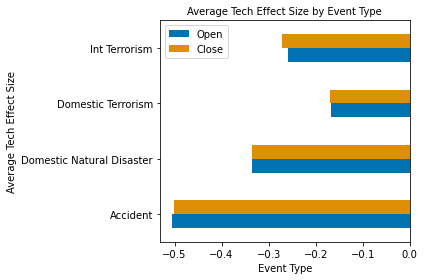

''

In [50]:
# cohens effect size tech
# Set the color palette
sns.set_palette("colorblind")

# Group the DataFrame by 'Type' and calculate the mean effect size for each measurement
avg_effect_size_by_type = effect_cohentech.groupby('Type')[['Open', 'Close']].mean()

# Create a bar plot
plt.figure(figsize=(22, 55))
avg_effect_size_by_type.plot(kind='barh')

# Adding labels and title
plt.xlabel('Event Type',fontsize=10)
plt.ylabel('Average Tech Effect Size',fontsize=10)
plt.title('Average Tech Effect Size by Event Type',fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()
;

In [51]:
grouped_oilb = techb.groupby('Type')
grouped_oila = techa.groupby('Type')

measurements = ['Open', 'High', 'Low', 'Close']

effect_sizes_dict = {'Type': []}

for measurement in measurements:
    effect_sizes_dict[measurement] = []

for group, group_data_oilb in grouped_oilb:
    group_data_oila = grouped_techa.get_group(group)
    
    effect_sizes_dict['Type'].append(group)
    
    for measurement in measurements:
        mean_oilb = group_data_oilb[measurement].mean()
        mean_oila = group_data_oila[measurement].mean()
        std_oilb = group_data_oilb[measurement].std()
        std_oila = group_data_oila[measurement].std()
        n_oilb = len(group_data_oilb)
        n_oila = len(group_data_oila)
        
        # Calculate Hedges' g effect size for the current measurement and group
        pooled_std = np.sqrt(((std_oilb ** 2 * (n_oilb - 1)) + (std_oila ** 2 * (n_oila - 1))) / (n_oilb + n_oila - 2))
        hedges_g = (mean_oila - mean_oilb) / pooled_std
        
        # Store the effect size for the current measurement
        effect_sizes_dict[measurement].append(hedges_g)

# Create a DataFrame from the effect_sizes_dict
effect_hedgetech = pd.DataFrame(effect_sizes_dict)
effect_hedgetech

,Type,Open,High,Low,Close
0,Accident,0.016412,-0.003828,-0.002833,-0.019144
1,Domestic Natural Disaster,0.007181,0.006849,0.007513,0.015992
2,Domestic Terrorism,-0.070410,-0.070278,-0.073202,-0.070192
3,Int Terrorism,-0.154571,-0.147373,-0.168951,-0.175280


## Oil vs Tech Open and Close Effect Size

### Open

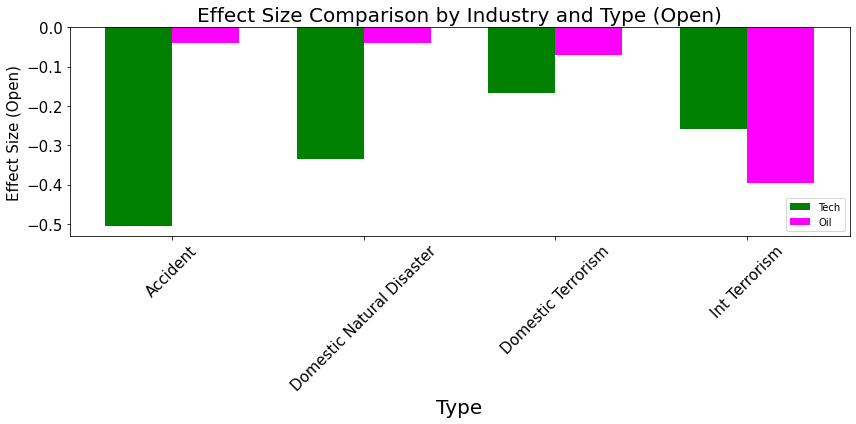

In [52]:
# Extract the types from the data frames
types = effect_cohentech['Type']

# Set the width of the bars
bar_width = 0.35

# Define the positions for the bars
ind = np.arange(len(types))

# Create a bar graph for effect size comparison by type

plt.figure(figsize=(12, 6))
plt.bar(ind, effect_cohentech['Open'], width=bar_width, label='Tech',color='green')
plt.bar(ind + bar_width, effect_cohen_oil['Open'], width=bar_width, label='Oil',color='magenta')

# Label settings
plt.tick_params(axis='y', labelsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.xlabel('Type',fontsize=20)
plt.ylabel('Effect Size (Open)',fontsize=15)
plt.title('Effect Size Comparison by Industry and Type (Open)',fontsize=20)
plt.xticks(ind + bar_width / 2, types, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


### Close

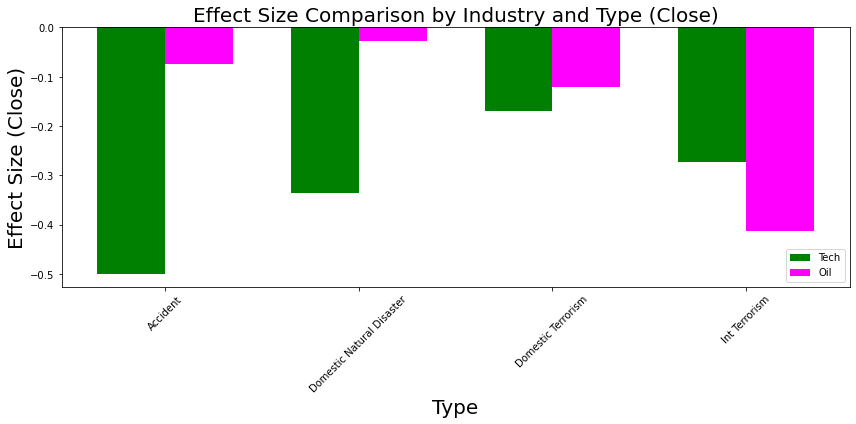

In [53]:
# Extract the types from the data frames
types = effect_cohentech['Type']

# Set the width of the bars
bar_width = 0.35

# Define the positions for the bars
ind = np.arange(len(types))

# Create a bar graph for effect size comparison by type
plt.figure(figsize=(12, 6))
plt.bar(ind, effect_cohentech['Close'], width=bar_width, label='Tech',color='green')
plt.bar(ind + bar_width, effect_cohen_oil['Close'], width=bar_width, label='Oil',color='magenta')

# Label settings
plt.xlabel('Type',fontsize=20)
plt.ylabel('Effect Size (Close)',fontsize=20)
plt.title('Effect Size Comparison by Industry and Type (Close)',fontsize=20)
plt.xticks(ind + bar_width / 2, types, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()
